In [ ]:
! pip install deepsnap

In [ ]:
! pip install torch-geometric

In [ ]:
!pip install torch-sparse

In [ ]:
!pip install torch-scatter

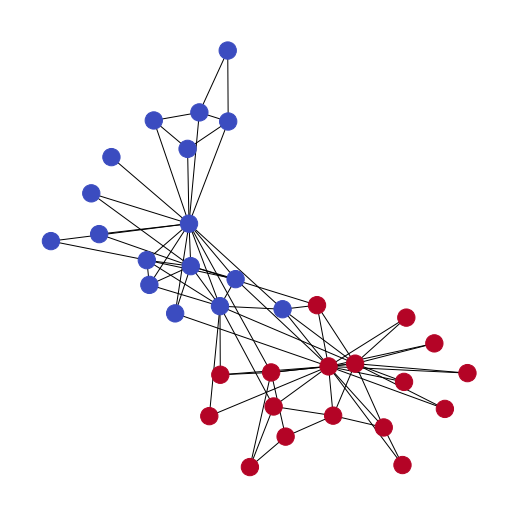

In [1]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        community_map[node[0]] = 0
    else:
        community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

(0, {'club': 'Mr. Hi', 'node_type': 'n0', 'node_feature': tensor([1., 1., 1., 1., 1.]), 'node_label': 0})
(0, 1, {'weight': 4, 'edge_type': 'e0'})


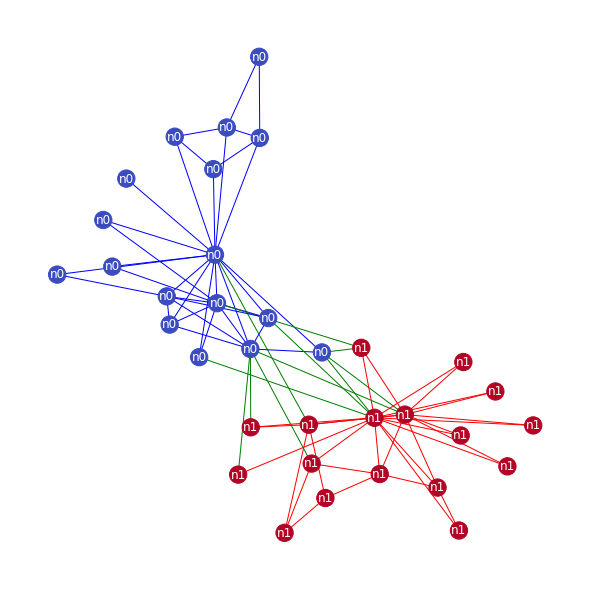

In [2]:
import torch

community_node = dict((k, "n" + str(v)) for k, v in community_map.items())
node_feature = dict(((node, torch.tensor([1, 1, 1, 1, 1.])) for node in G.nodes()))
node_label = dict((node[0], 0) if node[1]['club'] == 'Mr. Hi' else (node[0], 1) for node in G.nodes(data=True))
nx.classes.function.set_node_attributes(G, community_node, name='node_type')
nx.classes.function.set_node_attributes(G, node_feature, name='node_feature')
nx.classes.function.set_node_attributes(G, node_label, name='node_label')
community_edge = {}
edge_color = {}
for edge in G.edges():
    n1, n2 = edge
    community_edge[edge] = 'e' + str(community_map[n1]) if community_map[n1] == community_map[n2] else 'e2'
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
        edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
        edge_color[edge] = 'red'
    else:
        edge_color[edge] = 'green'
nx.classes.function.set_edge_attributes(G, community_edge, name='edge_type')
G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G, 'color').values()
for edge in G.edges(data=True):
    del edge[2]['color']
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

In [3]:
from deepsnap.hetero_graph import HeteroGraph

hetero = HeteroGraph(G_orig)
for edge in G_orig.edges(data=True):
    print(edge)
    break
print("Node types: {}".format(hetero.node_types))
print("Edge types: {}".format(hetero.edge_types))
print("Message types: {}".format(hetero.message_types))
for node_type in hetero.node_types:
    print("Node type {} has {} nodes".format(node_type, hetero.num_nodes(node_type)))
for message_type in hetero.message_types:
    print("Message type {} has {} edges".format(message_type, hetero.num_edges(message_type)))
print(hetero.node_feature)
print(hetero.node_label)

(0, 1, {'weight': 4, 'edge_type': 'e0'})
Node types: ['n0', 'n1']
Edge types: ['e2', 'e1', 'e0']
Message types: [('n0', 'e0', 'n0'), ('n0', 'e2', 'n1'), ('n1', 'e1', 'n1')]
Node type n0 has 17 nodes
Node type n1 has 17 nodes
Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges
{'n0': tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]), 'n1': tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 

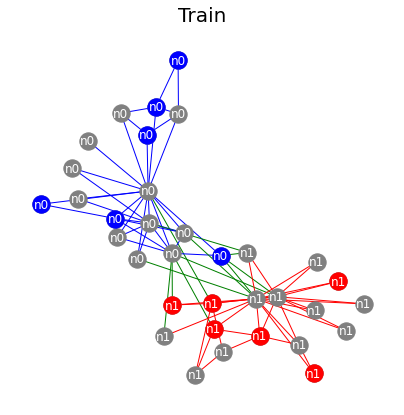

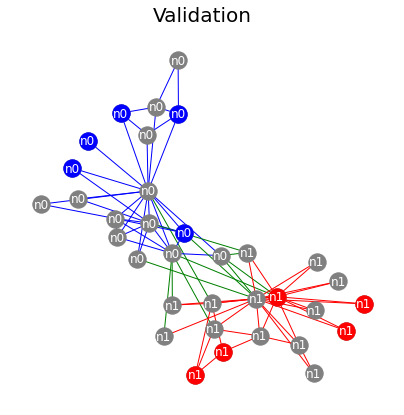

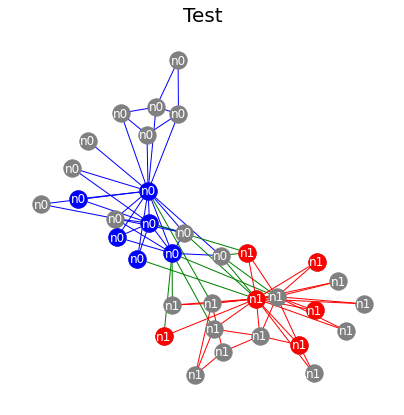

In [4]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hetero], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hetero._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hetero._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i], fontsize=20)
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

In [5]:
#!wget https://www.dropbox.com/s/gb6b3fixmaadltu/WN18.gpickle

## Creating data

In [6]:
import random
import torch
import networkx as nx
from deepsnap.hetero_graph import HeteroGraph

# Create an empty graph
G = nx.MultiDiGraph()

# Define the number of nodes for each type
num_advisors = 50
num_firms = 5

# Create advisor nodes
for i in range(num_advisors):
    node_feature = torch.Tensor([random.random() for _ in range(10)])  # Use torch.Tensor here
    G.add_node(i, node_type='advisor', node_feature=node_feature)

# Create firm nodes
for i in range(num_firms):
    node_feature = torch.Tensor([random.random() for _ in range(5)])  # Use torch.Tensor here
    G.add_node(i + num_advisors, node_type='firm', node_feature=node_feature)

# Connect advisors to firms with 'belong' edge type
for i in range(num_advisors):
    firm_id = random.randint(num_advisors, num_advisors + num_firms - 1)
    G.add_edge(i, firm_id, edge_type='belong')

# Connect advisors to advisors with 'same_title' edge type
num_same_title_edges = 10  # Add 10 'same_title' edges
for _ in range(num_same_title_edges):
    advisor1 = random.randint(0, num_advisors - 1)
    advisor2 = random.randint(0, num_advisors - 1)
    while advisor1 == advisor2:
        advisor2 = random.randint(0, num_advisors - 1)
    G.add_edge(advisor1, advisor2, edge_type='same_title')

# Create a HeteroGraph object
hetero = HeteroGraph(G)


In [7]:
# import pickle

# # Reading the gpickle file
# with open('WN18.gpickle', 'rb') as f:
#     G = pickle.load(f)

for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break
print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_type': 'advisor', 'node_feature': tensor([0.5592, 0.0167, 0.9053, 0.1901, 0.2412, 0.9424, 0.9748, 0.1594, 0.6019,
        0.9273])})
(0, 54, {'edge_type': 'belong'})
Number of edges is 60
Number of nodes is 55


In [8]:
# Functions to generate two internal GNN layers for link prediction task
def generate_2convs_link_pred_layers(hete, conv, hidden_size):
    convs1 = {}
    convs2 = {}
    for message_type in hete.message_types:
        n_type = message_type[0]
        s_type = message_type[2]
        n_feat_dim = hete.num_node_features(n_type)
        s_feat_dim = hete.num_node_features(s_type)
        convs1[message_type] = conv(n_feat_dim, hidden_size, s_feat_dim)
        convs2[message_type] = conv(hidden_size, hidden_size, hidden_size)
    return convs1, convs2

In [9]:
# Import required libraries and modules
from pprint import pprint
from deepsnap.hetero_graph import HeteroGraph
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.hetero_gnn import HeteroSAGEConv
from torch.utils.data import DataLoader

# Convert the NetworkX graph 'G' into a DeepSNAP HeteroGraph
hetero = HeteroGraph(G)

# Set the hidden layer size for the GNN layers
hidden_size = 32

# Generate two HeteroSAGEConv layers for a link prediction task with the specified hidden size
conv1, conv2 = generate_2convs_link_pred_layers(hetero, HeteroSAGEConv, hidden_size)

# Print out the details of the first convolutional layer
pprint(conv1)

# Print out the details of the second convolutional layer
pprint(conv2)

# Create a GraphDataset for link prediction from the HeteroGraph, with negative sampling ratio set to 2.0
dataset = GraphDataset([hetero], task='link_pred', edge_negative_sampling_ratio=2.0)

# Split the dataset into training, validation, and testing datasets with ratios 0.8, 0.1, and 0.1, respectively, in a transductive setting
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

# Create a DataLoader for the training set, using the Batch collate function, with batch size set to 1
train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=1)

# Create a DataLoader for the validation set, using the Batch collate function, with batch size set to 1
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=1)

# Create a DataLoader for the testing set, using the Batch collate function, with batch size set to 1
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=1)

# Group the DataLoaders into a dictionary for easy access during training and evaluation
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}


{('advisor', 'belong', 'firm'): HeteroSAGEConv(neigh: 10, self: 5, out: 32),
 ('advisor', 'same_title', 'advisor'): HeteroSAGEConv(neigh: 10, self: 10, out: 32)}
{('advisor', 'belong', 'firm'): HeteroSAGEConv(neigh: 32, self: 32, out: 32),
 ('advisor', 'same_title', 'advisor'): HeteroSAGEConv(neigh: 32, self: 32, out: 32)}


In [10]:
# Import necessary modules from PyTorch and DeepSNAP
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepsnap.hetero_gnn import forward_op, HeteroConv

# Define the HeteroGNN class which is a subclass of torch.nn.Module
class HeteroGNN(torch.nn.Module):
    # Initialize the HeteroGNN model with two convolution layers, the heterograph, and hidden size
    def __init__(self, conv1, conv2, hetero, hidden_size):
        super(HeteroGNN, self).__init__()

        # Initialize the first HeteroConv layer with conv1 configurations
        self.convs1 = HeteroConv(conv1)

        # Initialize the second HeteroConv layer with conv2 configurations
        self.convs2 = HeteroConv(conv2)

        # Define the loss function as Binary Cross Entropy with Logits
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

        # Create dictionaries to store batch normalization layers for each node type
        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()

        # Create dictionaries to store ReLU activation layers for each node type
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()

        # Get the node types and edge types from the heterograph
        self.node_types = hetero.node_types
        self.edge_types = hetero.edge_types
        
        # Initialize batch normalization and ReLU layers for each node type
        for node_type in self.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(hidden_size)
            self.bns2[node_type] = torch.nn.BatchNorm1d(hidden_size)
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()

    # Define the forward pass
    def forward(self, data):
        # Extract node features and edge index from the input data
        x = data.node_feature
        edge_index = data.edge_index

        # Apply the first HeteroConv layer
        x = self.convs1(x, edge_index)

        # Apply batch normalization followed by ReLU activation function for each node type
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)

        # Apply the second HeteroConv layer
        x = self.convs2(x, edge_index)

        # Again apply batch normalization for each node type
        x = forward_op(x, self.bns2)

        # Initialize an empty dictionary to store predictions
        pred = {}

        # Loop through each node type and edge type to compute predictions
        for node_type in self.node_types:
            for edge_type in self.edge_types:
                message_type = (node_type, str(edge_type), node_type)
                # If the edge type exists in the data's edge_label_index, then compute predictions
                if message_type in data.edge_label_index:
                    # Select the node embeddings based on the edge indices
                    nodes_first = torch.index_select(x[message_type[0]], 0, data.edge_label_index[message_type][0,:].long())
                    nodes_second = torch.index_select(x[message_type[2]], 0, data.edge_label_index[message_type][1,:].long())
                    # Calculate the dot product of the node embeddings for each edge to get the prediction
                    pred[message_type] = torch.sum(nodes_first * nodes_second, dim=-1)
        return pred

    # Define the loss calculation
    def loss(self, pred, y):
        # Initialize loss as 0
        loss = 0
        # For each edge type, calculate and sum up the loss
        for key in pred:
            p = torch.sigmoid(pred[key])  # Apply sigmoid activation to the predictions
            loss += self.loss_fn(p, y[key].type(pred[key].dtype))  # Compute and add BCEWithLogitsLoss
        return loss


In [11]:
import numpy as np
import copy

# Function to train the model
def train(model, dataloaders, optimizer, args):
    # Initialize the best validation score and a copy of the model
    val_max = 0
    best_model = model

    # Lists to store accuracy metrics for each epoch
    t_accu = []
    v_accu = []
    e_accu = []

    # Loop over the number of epochs
    for epoch in range(1, args["epochs"] + 1):
        # Loop over each batch in the training dataloader
        for iter_i, batch in enumerate(dataloaders['train']):
            # Move the batch to the designated computing device
            batch.to(args["device"])

            # Set the model to training mode
            model.train()

            # Reset the gradients
            optimizer.zero_grad()

            # Forward pass: Compute predictions from the model
            pred = model(batch)

            # Compute the loss
            loss = model.loss(pred, batch.edge_label)

            # Backward pass: Compute gradient of the loss with respect to model parameters
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # Log and print the training status
            log = 'Epoch: {:03d}, Train loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            
            # Test the model performance after this training step
            accs = test(model, dataloaders, args)

            # Append the accuracy metrics to their respective lists
            t_accu.append(accs['train'])
            v_accu.append(accs['val'])
            e_accu.append(accs['test'])

            # Print the current metrics
            print(log.format(epoch, loss.item(), accs['train'], accs['val'], accs['test']))

            # Check if the current validation accuracy is the best so far
            # If so, update val_max and save a deep copy of the model
            if val_max < accs['val']:
                val_max = accs['val']
                best_model = copy.deepcopy(model)

    # Log and print the best performance over all epochs
    log = 'Best: Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    accs = test(best_model, dataloaders, args)
    print(log.format(accs['train'], accs['val'], accs['test']))

    # Return the accuracy metrics lists
    return t_accu, v_accu, e_accu

# Function to test the model's performance
def test(model, dataloaders, args):
    # Set the model to evaluation mode
    model.eval()

    # Dictionary to store accuracy metrics
    accs = {}

    # Loop over each mode (train, val, test) and its corresponding dataloader
    for mode, dataloader in dataloaders.items():
        # Initialize accuracy and count
        acc = 0
        num = 0

        # Loop over each batch in the dataloader
        for i, batch in enumerate(dataloader):
            # Move the batch to the designated computing device
            batch.to(args["device"])

            # Forward pass: Compute predictions from the model
            pred = model(batch)

            # Loop over each prediction and corresponding label
            for key in pred:
                # Apply sigmoid function and convert tensor to NumPy array
                p = torch.sigmoid(pred[key]).cpu().detach().numpy()

                # Initialize prediction labels as zeros
                pred_label = np.zeros_like(p, dtype=np.int64)

                # Assign predictions as 1 where the model's output is greater than 0.5
                pred_label[np.where(p > 0.5)[0]] = 1

                # Assign predictions as 0 where the model's output is less than or equal to 0.5
                pred_label[np.where(p <= 0.5)[0]] = 0

                # Count how many predictions match the actual labels
                acc += np.sum(pred_label == batch.edge_label[key].cpu().numpy())

                # Increment the total number of predictions
                num += len(pred_label)

        # Calculate the accuracy for the current mode
        accs[mode] = acc / num

    # Return the dictionary of accuracy metrics
    return accs



In [12]:
# Define a dictionary named `args` with hyperparameters and settings
args = {
    "device": "cpu",               # Device to run the model on ('cpu' or 'cuda')
    "epochs": 50,                  # Number of epochs for training
    "lr": 0.01,                    # Learning rate for optimizer
    "weight_decay": 1e-4           # Weight decay (L2 penalty) for regularization in optimizer
}

# Instantiate the HeteroGNN model with the previously created convolutional layers, heterograph, and hidden size
# Then, move the model to the computing device specified in `args` (in this case, CPU)
model = HeteroGNN(conv1, conv2, hetero, hidden_size).to(args["device"])

# Create an optimizer (Adam) for updating the model's weights.
# It uses the learning rate and weight decay values specified in `args`
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Train the model using the train function defined earlier, passing in the model, dataloaders, optimizer, and args
# This function will return training, validation, and test accuracies for each epoch, which are captured in t_accu, v_accu, and e_accu respectively
t_accu, v_accu, e_accu = train(model, dataloaders, optimizer, args)

Epoch: 001, Train loss: 0.7783, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 002, Train loss: 0.9167, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 003, Train loss: 0.7922, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 004, Train loss: 0.7977, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 005, Train loss: 0.8532, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 006, Train loss: 0.8311, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 007, Train loss: 0.8317, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 008, Train loss: 0.8146, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 009, Train loss: 0.7577, Train: 0.3750, Val: 0.3333, Test: 0.3333
Epoch: 010, Train loss: 0.7873, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 011, Train loss: 0.7392, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 012, Train loss: 0.8044, Train: 0.3333, Val: 0.3333, Test: 0.3333
Epoch: 013, Train loss: 0.8161, Train: 0.4167, Val: 0.3333, Test: 0.3333
Epoch: 014, Train loss: 0.7455, Train: 0.6250, Val:

In [13]:
# Function to calculate precision, recall, and accuracy from true positives, false positives, true negatives, and false negatives
def calculate_metrics(tp, fp, tn, fn):
    # Calculate precision. Avoid division by zero by checking if the denominator is greater than 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Calculate recall. Avoid division by zero by checking if the denominator is greater than 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Calculate accuracy. Avoid division by zero by checking if the denominator is greater than 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    # Return the calculated metrics
    return precision, recall, accuracy

# Function to test the model specifically for the 'belong' edge type and compute metrics
def test_for_belong(model, dataloaders, args):
    # Set the model to evaluation mode. This will deactivate dropout layers and batch normalization, etc.
    model.eval()
    # Initialize a dictionary to store the true positives, false positives, true negatives, and false negatives for train, validation, and test datasets
    metrics = {'train': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
               'val': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0},
               'test': {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}}

    # Iterate over each set (train, validation, test) and their respective dataloaders
    for mode, dataloader in dataloaders.items():
        # Iterate over each batch in the dataloader
        for i, batch in enumerate(dataloader):
            # Move the batch to the specified device (e.g., CPU or GPU)
            batch.to(args["device"])
            # Run the model prediction on the batch
            pred = model(batch)

            # Focus only on the 'belong' edge type in predictions
            for key in pred:
                # Skip if the edge type is not 'belong'
                if key[1] != 'belong':
                    continue
                # Apply sigmoid function to predictions and move them to CPU, converting them to numpy array
                p = torch.sigmoid(pred[key]).cpu().detach().numpy()
                # Convert probabilities to binary class labels (1 if p > 0.5, otherwise 0)
                pred_label = (p > 0.5).astype(np.int64)
                # Get the true labels and convert to numpy array
                true_label = batch.edge_label[key].cpu().numpy()

                # Increment true positive, false positive, true negative, and false negative counts based on prediction and true labels
                metrics[mode]['tp'] += np.sum((pred_label == 1) & (true_label == 1))
                metrics[mode]['fp'] += np.sum((pred_label == 1) & (true_label == 0))
                metrics[mode]['tn'] += np.sum((pred_label == 0) & (true_label == 0))
                metrics[mode]['fn'] += np.sum((pred_label == 0) & (true_label == 1))

    # Iterate over each set (train, val, test) to calculate and print precision, recall, and accuracy
    for mode in metrics:
        # Unpack the true positives, false positives, true negatives, and false negatives for the current mode
        tp, fp, tn, fn = metrics[mode].values()
        # Calculate precision, recall, and accuracy using the calculate_metrics function
        precision, recall, accuracy = calculate_metrics(tp, fp, tn, fn)
        # Print the calculated metrics
        print(f"{mode} Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")


In [14]:
test_for_belong(model, dataloaders, args)

train Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000
val Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000
test Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000


In [20]:
model

HeteroGNN(
  (convs1): HeteroConv(
    (modules): ModuleList(
      (0): HeteroSAGEConv(neigh: 10, self: 5, out: 32)
      (1): HeteroSAGEConv(neigh: 10, self: 10, out: 32)
    )
  )
  (convs2): HeteroConv(
    (modules): ModuleList(
      (0-1): 2 x HeteroSAGEConv(neigh: 32, self: 32, out: 32)
    )
  )
  (loss_fn): BCEWithLogitsLoss()
  (bns1): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (firm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bns2): ModuleDict(
    (advisor): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (firm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relus1): ModuleDict(
    (advisor): LeakyReLU(negative_slope=0.01)
    (firm): LeakyReLU(negative_slope=0.01)
  )
  (relus2): ModuleDict(
    (advisor): LeakyReLU(negative_slope=0.01)
    (firm): LeakyReLU(negative_slope=0.01)
  )
 